# 1 Node2vec
For the **biased random walk**, implementation from [StellarGraph](https://stellargraph.readthedocs.io/en/stable/)  
For Word2Vec implementation from [Gensim](https://radimrehurek.com/gensim/models/word2vec.html)

In [1]:
# Packages
import numpy as np
import pandas as pd
from zipfile import ZipFile
import networkx as nx
from fastprogress import master_bar, progress_bar

from sklearn.manifold import TSNE
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error

import multiprocessing
from collections import defaultdict
import random as rd
rd.seed(1)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from gensim.models import Word2Vec

StellarGraph

In [4]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  !pip install -q stellargraph[demos]

In [5]:
from stellargraph import StellarGraph
import stellargraph as sg

In [6]:
from stellargraph.data import BiasedRandomWalk

Mount google drive

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:
PATH_FOLDER = '/content/gdrive/MyDrive/Colab Notebooks/graph_based_recommendation_system'
%cd {PATH_FOLDER}

/content/gdrive/.shortcut-targets-by-id/1Qu7UOLxDtaHg6JbrDo0q-3e4ePr807CH/graph_based_recommendation_system


In [9]:
%ls

data/                  GraphCentralities.ipynb  README.md
DataExploration.ipynb  Node2vec.ipynb           saved_model/
figures/               project_proposal.docx
GNN.ipynb              project_proposal.pdf


## 1.2 Parameters

In [10]:
# maximum length of a random walk 
walk_length = 10  

# k = nodes sample out of the total amount
# to stay consinstent with GNN implementation
k = 15000

train_size = 0.7
val_size = 0.25
test_size = 0.3

seed = 11

## 1.1 Load data

### 1.1.1 Load DataFrames

In [11]:
# Loading dataset from .zip file
path_dataset = "data/dataset.zip"

with ZipFile(path_dataset, 'r') as zip_ref:
    all_path = zip_ref.namelist()
    print('Paths: ', all_path)
    
    df_anime = pd.read_csv(zip_ref.open(all_path[0]))
    df_rating = pd.read_csv(zip_ref.open(all_path[1]))

Paths:  ['anime.csv', 'rating.csv']


Elimination of rows that have Nan values

In [12]:
#df_anime.dropna(inplace=True)
df_rating.dropna(inplace=True)

Elimination of all rating values whose anime doesn't have a description in file 'anime.csv'

In [13]:
for i in df_rating.anime_id.unique():
  if df_anime[df_anime['anime_id'] == i].empty:
    df_rating = df_rating[df_rating['anime_id'] != i]

Elimination of all user-item interactions when a rate has not been given (rating = -1)

In [14]:
# number of user that have seen an anime, but didn't give a rate (meaning rating = -1)
df_rating[df_rating['rating'] == -1].rating.value_counts()

-1    1476488
Name: rating, dtype: int64

In [15]:
# new dataframe without user-item intercations with rating = -1
new_df_rating = df_rating[df_rating['rating'] != -1]
assert(new_df_rating.shape[0] == df_rating.shape[0] - 1476488)

df_rating = new_df_rating
del new_df_rating

Number of possible nodes and edges after the pre-processing phase

In [16]:
num_users = len(df_rating['user_id'].unique())
num_items = len(df_rating['anime_id'].unique())
num_nodes = num_users + num_items

print('Number of nodes: ', num_nodes)
print('Number of edges: ', df_rating.shape[0])

Number of nodes:  79526
Number of edges:  6337239


### 1.1.2 Load graph

In [17]:
G = nx.readwrite.edgelist.read_weighted_edgelist('./data/graph.edgelist')

In [18]:
# Add user node type
for i in df_rating.user_id.unique():
  attrs = {'user_' + str(i): {'node_type':'user'}}
  nx.set_node_attributes(G, attrs)

# Add anime node type
for i in df_rating.anime_id.unique():
  attrs = {'anime_' + str(i): {'node_type':'anime'}}
  nx.set_node_attributes(G, attrs)

Stellar Graph

In [19]:
rd.seed(seed)
k_nodes = rd.sample(list(G.nodes()), k=k)
subG = G.subgraph(k_nodes)

userList = [n for n,d in subG.nodes(data=True) if d['node_type'] == 'user']
animeList = [n for n,d in subG.nodes(data=True) if d['node_type'] == 'anime']

num_users = len(set(userList))
num_items = len(set(animeList))

print('Number of users: ', num_users)
print('Number of animes: ', num_items)
print()
print('[Info] Number of NODES: ', num_users + num_items)
print('[Info] Number of EDGES: ', len(subG.edges()))

Number of users:  13176
Number of animes:  1824

[Info] Number of NODES:  15000
[Info] Number of EDGES:  204188


In [20]:
data_user = defaultdict()
data_anime = defaultdict()


# --------- Users features ------------
# -------------------------------------
for i in userList:
  avg_rating = np.mean([e[2]['weight'] for e in G.edges(i, data=True)])
  data_user[i] = avg_rating

user_features = pd.DataFrame.from_dict(data_user, orient='index', columns=['avg_rating'])
  

# --------- Anime features ------------
# -------------------------------------
for i in animeList:
  # RATING
  code = int(i[6:])
  rating = df_anime[df_anime['anime_id']==code].rating.to_string(index=False)
  if rating != 'NaN':
    rating = float(rating[1:])
  else:
    rating = 0.0

  # MEMBERS
  members = int(df_anime[df_anime['anime_id']==code].members.to_string(index=False)[1:])
  
  # FEATURES
  data_anime[i] = [rating, members]
  

anime_features = pd.DataFrame.from_dict(data_anime, orient='index', columns=['rating', 'members'])

In [21]:
g = StellarGraph.from_networkx(subG, node_type_attr='node_type', edge_weight_attr='weight', edge_type_default='rating',
                               node_features={'user': user_features, 'anime': anime_features})
print(g.info())

StellarGraph: Undirected multigraph
 Nodes: 15000, Edges: 204188

 Node types:
  user: [13176]
    Features: float32 vector, length 1
    Edge types: user-rating->anime
  anime: [1824]
    Features: float32 vector, length 2
    Edge types: anime-rating->user

 Edge types:
    anime-rating->user: [204188]
        Weights: range=[1, 10], mean=7.73572, std=1.58237
        Features: none


## 1.3 Embeddings generator


### 1.3.1 node embeddings

In [22]:
# Biased random walks
rw = BiasedRandomWalk(g)

weighted_walks = rw.run(
    nodes=g.nodes(),  # root nodes
    length=walk_length,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
    weighted=True,  # for weighted random walks
    seed=seed,  # random seed fixed for reproducibility
)
print("Number of random walks: {}".format(len(weighted_walks)))

Number of random walks: 150000


In [23]:
weighted_model = Word2Vec(
    weighted_walks, size=128, window=5, min_count=0, sg=1, workers=1, iter=1
)

### 1.3.2 edge embeddings

In [24]:
# Retrieve node embeddings
node_ids = weighted_model.wv.index2word  # list of node IDs
weighted_node_embeddings = (weighted_model.wv.vectors) 

In [25]:
X = []  # feature vectors
y = []  # labels

for e in list(subG.edges(data=True)):
  n1 = e[0]
  n2 = e[1]
  if n1[:5] == 'anime':
    a = n1
    u = n2
  else:
    a = n2
    u = n1 

  r = e[2]['weight']

  # edge (node embeddings concatenation)
  emb1 = weighted_model.wv[u]
  emb2 =  weighted_model.wv[a]
  concat = np.concatenate((emb1, emb2))

  X.append(concat)
  y.append(r)

## 1.4 Link prediction

### 1.4.1 Train, validation and test sets

In [26]:
X_train_val, X_test, y_train_val, y_test = model_selection.train_test_split(
    X, y, train_size=train_size, test_size=test_size, random_state=seed
)

X_train, X_val, y_train, y_val = model_selection.train_test_split(
    X_train_val, y_train_val , test_size=val_size, random_state=seed
)

In [27]:
print('Training set: \n{} feature vectors \n{} labels'.format(len(X_train), len(y_train)))
print()
print('Val set: \n{} feature vectors \n{} labels'.format(len(X_val), len(y_val)))
print()
print('Test set: \n{} feature vectors \n{} labels'.format(len(X_test), len(y_test)))

Training set: 
107198 feature vectors 
107198 labels

Val set: 
35733 feature vectors 
35733 labels

Test set: 
61257 feature vectors 
61257 labels


In [28]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

### 1.4.2 Neural Network



In [29]:
import tensorflow as tf

model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
  tf.keras.layers.Dense(1, activation='relu'),
])

In [30]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=1e-2),
    loss=tf.losses.mean_squared_error,
    metrics=[tf.metrics.RootMeanSquaredError(), tf.metrics.mae],
)

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________


In [32]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_loss', restore_best_weights=True)]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    verbose=1,
    shuffle=False,
)

Epoch 1/30
3350/3350 [==============================] - 7s 2ms/step - loss: 2.4130 - root_mean_squared_error: 1.5534 - mean_absolute_error: 1.1913 - val_loss: 2.2341 - val_root_mean_squared_error: 1.4947 - val_mean_absolute_error: 1.1506
Epoch 2/30
3350/3350 [==============================] - 6s 2ms/step - loss: 2.1853 - root_mean_squared_error: 1.4783 - mean_absolute_error: 1.1492 - val_loss: 2.2137 - val_root_mean_squared_error: 1.4878 - val_mean_absolute_error: 1.1447
Epoch 3/30
3350/3350 [==============================] - 6s 2ms/step - loss: 2.1664 - root_mean_squared_error: 1.4719 - mean_absolute_error: 1.1443 - val_loss: 2.1965 - val_root_mean_squared_error: 1.4821 - val_mean_absolute_error: 1.1403
Epoch 4/30
3350/3350 [==============================] - 6s 2ms/step - loss: 2.1533 - root_mean_squared_error: 1.4674 - mean_absolute_error: 1.1409 - val_loss: 2.1844 - val_root_mean_squared_error: 1.4780 - val_mean_absolute_error: 1.1371
Epoch 5/30
3350/3350 [==========================

Test:

In [33]:
y_pred = model.predict(X_test)

In [36]:
np.savetxt('./saved_model/y_pred_node2vec.txt', y_pred)

In [37]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print("\nModel Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)


Model Test set metrics:
	root_mean_square_error =  1.454370965551964
	mean_absolute_error =  1.1236939219362654


Compare the distributions of predicted and true rankings for the test set:

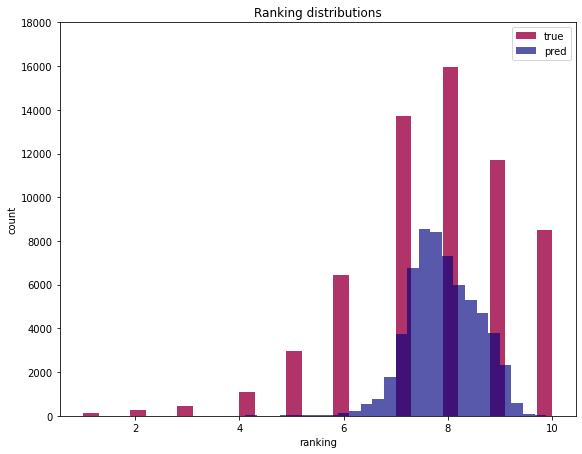

In [38]:
fig, ax = plt.subplots(figsize=(8,6))

num_color = 3
col = [plt.cm.Spectral(i/float(num_color-1)) for i in range(num_color)]

ax.hist(y_test, bins=30, facecolor=col[0], alpha=0.8, label='true')
ax.hist(y_pred, bins=30, facecolor='navy', alpha=0.65, label='pred')

fig.tight_layout()

plt.ylim(top=18000)

plt.title('Ranking distributions')
plt.xlabel("ranking")
plt.ylabel("count")
plt.legend()

#if SAVE: plt.savefig('./figures/ranking_distributions_node2vec.jpg', bbox_inches = 'tight')
plt.show()